In [1]:
using LinearAlgebra, SparseArrays

using ForwardDiff
using NLsolve, LineSearches

using BenchmarkTools

using Plots
using LaTeXStrings

using gmsh

# Define Permeability
The permeability is extracted from the datasheet of the core material (3C92) and fitted to an analytical expression.

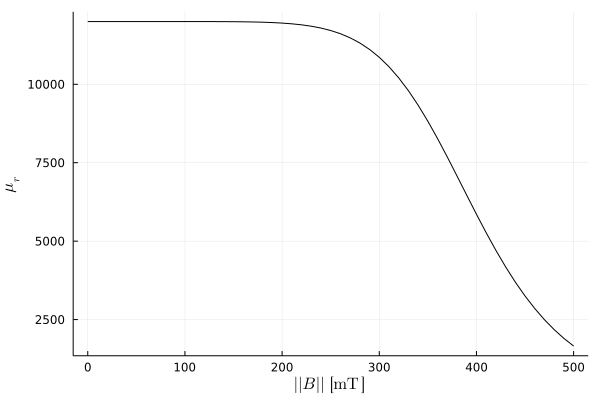

In [2]:
# Permeability function
a = 1 / 12000; 
b = 4;
c = 7.5;
mu0 = 4e-7 * pi;
fmur_core(B) = 1 / (a + (1 - a) * B^(2*b) / (B^(2*b) + c));

#a = 152.9e-3;
#b = 0.1071;
#fmur_core(B) = (b * max(B, 1e-3)) / (mu0 * sinh(max(B, 1e-3) / a));

B = Vector(0.:0.01:0.5);
plot(B * 1e3, fmur_core.(B), color = :black, xlabel = L"||B||\,\mathrm{[mT]}", ylabel = L"\mu_r", legend = false)

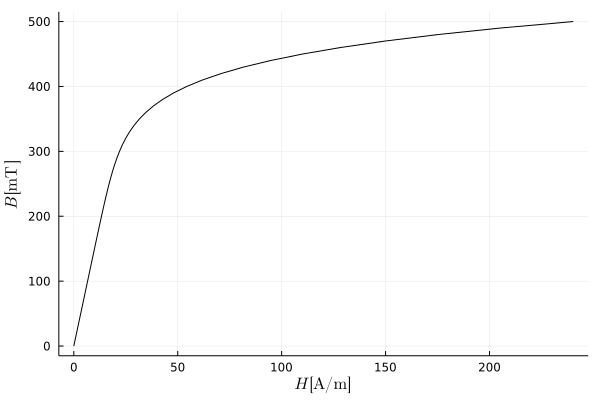

In [3]:
plot(B ./ (mu0 * fmur_core.(B)), B * 1e3, color = :black, xlabel = L"H\,\mathrm{[A/m]}", ylabel = L"B\,\mathrm{[mT]}", legend = false)

# Define Geometry

In [4]:
gmsh.finalize();
gmsh.initialize();

In [5]:
gmsh.open("geo/coil_geo.msh")

# Retrieve nodes from gmsh and sort in order of x-coords
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
xnode = node_coord[1:3:end];
p = sortperm(xnode);
x = xnode[p];
nids = node_ids[p];

Info    : Reading 'geo/coil_geo.msh'...
Info    : 15 entities
Info    : 114 nodes
Info    : 115 elements
Info    : Done reading 'geo/coil_geo.msh'


In [6]:
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(1)
nelements = length(element_ids[1])

ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1)
ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 2)
ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 3)
ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 4)
e_group = zeros(1,nelements)

for element_id in 1:nelements
    node1_id = element_connectivity[1][2*(element_id-1)+1]
    node2_id = element_connectivity[1][2*(element_id-1)+2]

    G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1]) # Air
    G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1]) # Core
    G3 = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1]) # Coil left
    G4 = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1]) # Coil right
    
    if G1 == 2
        e_group[element_id] = 1;
    elseif G2 == 2
        e_group[element_id] = 2;
    elseif G3 == 2
        e_group[element_id] = 3;
    elseif G4 == 2
        e_group[element_id] = 4;
    end
end

# Linear Elements

In [7]:
#..Set the source function 
J = 2.2e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

In [8]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
N = length(x);
points = collect( [x[i], x[i+1]] for i in 1:N-1) 
edges  = collect( [i, i+1] for i in 1:N-1); 

In [9]:
function allocate_matrices(datatype::DataType)
    A = spzeros(datatype, N, N)
    f = zeros(datatype, N)
    
    for i=1:length(edges) 
        Aloc = [1 -1; -1 1];
        A[edges[i], edges[i]] += Aloc;
    end

    #..handle the boundary conditions in the matrix and right-hand side vector 
    A[1,:]   = zeros(N);  A[1,1]     = 1;      f[1]   = 0;
    A[end,:] = zeros(N);  A[end,end] = 1;      f[end]   = 0;
    
    fill!(A.nzval, zero(datatype))
    
    return A, f
end

allocate_matrices (generic function with 1 method)

In [10]:
function assemble_matrices!(A::SparseMatrixCSC, f::Vector, u::Vector)
    #..Initialize global matrix and right-hand side value 
    fill!(A.nzval, 0)
    fill!(f, 0)
    
    B = abs.(diff(u) ./ diff(x));
    fnu_elem = map(fnu, e_group, B);
    
    Ae = zeros(eltype(u), 2, 2)
    fe = zeros(eltype(u), 2)
    
    ftempl = [1; 1];
    Atempl = [1 -1; -1 1];

    #..Perform loop over elements and assemble global matrix and vector 
    for i=1:length(edges) 
        xl, xr = points[i,:][1]
        h = xr - xl;

        fe[:] = h/2 * ftempl * fsource_elem[i];
        Ae[:] = fnu_elem[i] / h * Atempl;
        
        f[edges[i]] += fe;
        A[edges[i], edges[i]] += Ae;
    end

    #..handle the boundary conditions in the matrix and right-hand side vector 
    A[1,:]   .= 0;  A[1,1]     = 1;      f[1]   = 0;
    A[end,:] .= 0;  A[end,end] = 1;      f[end]   = 0;
    
    return A, f;
end

function res!(R, u)
    assemble_matrices!(A, f, u);
    R[:] = A * u - f;
end

res! (generic function with 1 method)

In [11]:
A, f = allocate_matrices(Float64)
assemble_matrices!(A, f, zeros(size(x)))
ulin = A \ f;

results = nlsolve(res!, ulin, autodiff = :finite, show_trace = :true)
u = results.zero;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.030969e+06              NaN
     1     3.169013e+02     4.155030e-01
     2     3.030969e+06     2.576150e-21
     3     3.030969e+06     0.000000e+00
     4     1.455604e+06     4.235165e-22
     5     6.497099e+04     0.000000e+00
     6     1.293992e+02     5.193790e-02
     7     2.330027e+01     3.312023e-03
     8     9.604978e-01     5.751808e-04
     9     3.059389e-03     2.549244e-05
    10     4.279677e-06     8.183144e-08
    11     6.165489e-09     1.143415e-10


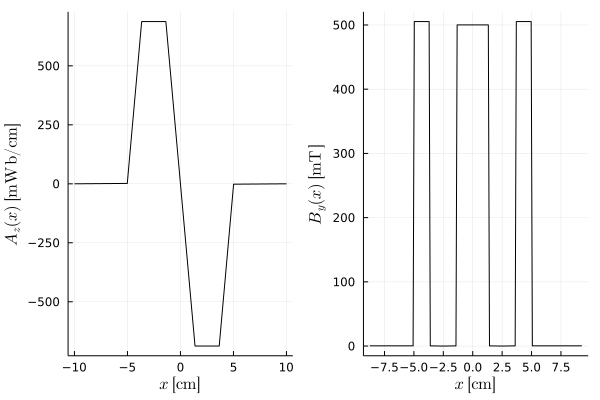

In [12]:
# Post-processing
xmid = diff(x) / 2 + x[1:end-1];
ux = diff(u) ./ diff(x);

# Plot
p1 = plot(x * 1e2, u * 1e5, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"A_z(x)\ \mathrm{[mWb/cm]}", color = :black, lw = 1, legend = false);
p2 = plot(xmid * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false);

plot(p1, p2)

# Linear Elements & Eddy Currents

In [111]:
#..Set the source function 
J = 2.2e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

sigma_core = 0.2;
fsigma(group_id) = sigma_core * (group_id == 2);
fsigma_elem = map(fsigma, e_group)

f     = 10e6;
omega = 2*pi*f;

In [112]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
N = length(x);
points = collect( [x[i], x[i+1]] for i in 1:N-1) 
edges  = collect( [i, i+1] for i in 1:N-1); 

function calc_fnu(u, x)
    B = abs.(diff(u) ./ diff(x));
    fnu_elem = map(fnu, e_group, B);
    
    return fnu_elem;
end

function assemble_matrices(u::Vector, fsource_elem, fsigma_elem)
    # Initialize vectors for sparse matrix construction
    I = zeros(Int64, 4*length(edges))
    J = similar(I);
    V = zeros(Complex{Float64}, length(I));
    
    # Initialize right-hand side vector
    f = zeros(Complex{Float64}, N);
    
    fnu_elem = calc_fnu(u, x)
    
    #..Perform loop over elements and assemble global matrix and vector 
    for (i, nodes) = enumerate(edges)
        idx = 4*(i-1) + 1 : 4*i;
        h   = points[i][2] - points[i][1];
        
        #
        f[nodes] += fsource_elem[i] * h / 2 * [1; 1];
        
        # Matrix contribution
        I[idx] = nodes[[1, 2, 1, 2]];
        J[idx] = nodes[[1, 1, 2, 2]];
        V[idx] = fnu_elem[i] / h * [1 -1 -1 1] + 1im * omega * fsigma_elem[i] * h * [1/3 1/6 1/6 1/3];
    end
    
    A = sparse(I, J, V)
    
    #..handle the boundary conditions in the matrix and right-hand side vector 
    A[1,:]   = zeros(N);  A[1,1]     = 1;      f[1]   = 0;
    A[end,:] = zeros(N);  A[end,end] = 1;      f[end] = 0;
    
    return A, f
end

function res!(R, u)
    A, f = assemble_matrices(u, fsource_elem, fsigma_elem);
    R[:] = A * u - f;
end

res! (generic function with 1 method)

In [82]:
@benchmark assemble_matrices(ulin, fsource_elem, fsigma_elem)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  187.100 μs …   6.650 ms  ┊ GC (min … max):  0.00% … 95.63%
 Time  (median):     194.000 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   233.256 μs ± 351.729 μs  ┊ GC (mean ± σ):  11.71% ±  7.44%

  ▆█▇▆▅▄▂▂▁  ▁▁  ▁▂▁▁▁                       ▁▃▃▁               ▂
  █████████████████████████▇▇▆▆▆▆▅▅▅▅▅▃▄▄▃▄▅▅████▇▇▇▁▅▅▃▅▃▅▄▄▄▆ █
  187 μs        Histogram: log(frequency) by time        371 μs <

 Memory estimate: 278.16 KiB, allocs estimate: 4913.

In [113]:
A, f = assemble_matrices(zeros(N), fsource_elem, fsigma_elem)
ulin = A \ f;

initial_F = similar(ulin)
initial_J = similar(A)
df = OnceDifferentiable(res!, ulin, initial_F, initial_J)
@time results = nlsolve(df, ulin, method = :newton, linesearch = BackTracking(order = 2))
u = results.zero;

print("Converged: ", results.f_converged, " (residual norm: ", results.residual_norm, ", evaluations: ", df.f_calls, "/", df.df_calls, ")\n")

 11.248946 seconds (215.05 M allocations: 11.614 GiB, 10.84% gc time, 2.00% compilation time)
Converged: true (residual norm: 8.894726872632041e-9, evaluations: [248]/[185])


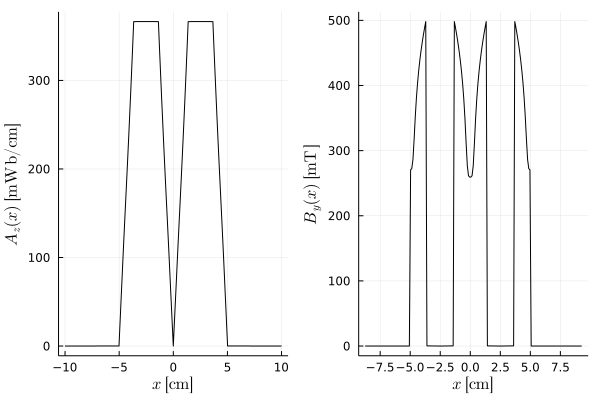

In [114]:
# Post-processing
xmid = diff(x) / 2 + x[1:end-1];
ux = diff(u) ./ diff(x);
Jeddy = 1im * omega * Transpose(fsigma_elem) .* (u[1:end-1] + u[2:end]) / 2;

# Plot
p1 = plot(x * 1e2, norm.(u) * 1e5, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"A_z(x)\ \mathrm{[mWb/cm]}", color = :black, lw = 1, legend = false);
p2 = plot(xmid * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false);

plot(p1, p2)

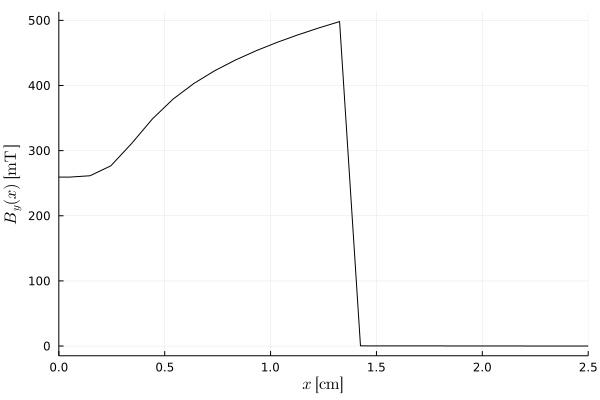

In [115]:
plot(xmid * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false)
xlims!((0, 2.5))

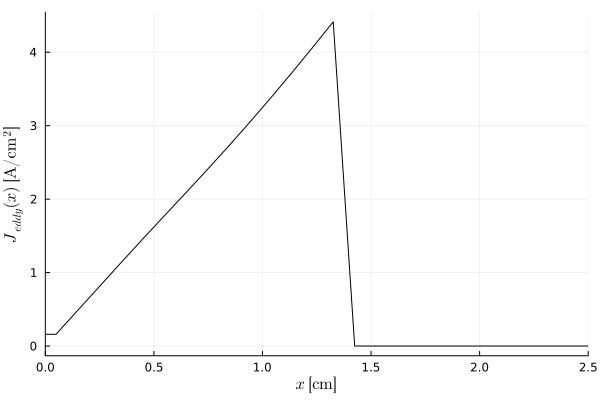

In [116]:
plot(xmid * 1e2, norm.(Jeddy) * 1e-4, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"J_{eddy}(x)\ \mathrm{[A/cm^2]}", color = :black, lw = 1, legend = false)
xlims!((0, 2.5))

# Quadratic Elements & Eddy Currents

In [105]:
#..Set the source function 
J = 2.2e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

sigma_core = 0.2;
fsigma(group_id) = sigma_core * (group_id == 2);
fsigma_elem = map(fsigma, e_group)

f     = 10e6;
omega = 2*pi*f;

In [106]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
Na = 2 * length(x) - 1;
points = collect( [x[i], 0.5*(x[i] + x[i+1]), x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1, i+2] for i in 1:2:Na-1); 

X = collect([points[i][1], points[i][2]] for i in 1:length(points))
X = reduce(vcat, X);
X = vcat(X, x[end]);

function calc_fnu(u, x)
    #B = abs.(diff(u) ./ diff(x));
    B = zeros(Na);
    Emat = 2 * [2, -4, 2] * [0 0.5 1] .+ [-3, 4, -1];
    for i=1:length(edges) 
        xl, xm, xr = points[i,:][1];
        ul, um, ur = u[edges[i]];

        dux  = [ul um ur] * Emat / (xr - xl);
        B[i] = norm.(dux[2]);
    end
    
    fnu_elem = map(fnu, e_group, B);
    
    return fnu_elem;
end

function assemble_matrices(u::Vector, fsource_elem, fsigma_elem)
    # Initialize vectors for sparse matrix construction
    I = zeros(Int64, 9*length(edges))
    J = similar(I);
    V = zeros(Complex{Float64}, length(I));
    
    # Initialize right-hand side vector
    f = zeros(Complex{Float64}, Na);
    
    fnu_elem = calc_fnu(u, X)
    
    #..Perform loop over elements and assemble global matrix and vector 
    for (i, nodes) = enumerate(edges)
        idx = 9*(i-1) + 1 : 9*i;
        h   = points[i][2] - points[i][1];
        
        #
        f[nodes] += fsource_elem[i] * h / 6 * [1; 4; 1];
        
        # Matrix contribution
        I[idx] = nodes[[1, 2, 3, 1, 2, 3, 1, 2, 3]];
        J[idx] = nodes[[1, 1, 1, 2, 2, 2, 3, 3, 3]];
        V[idx] = fnu_elem[i] / (3*h) * [7 -8 1 -8 16 -8 1 -8 7] + 1im * omega * fsigma_elem[i] * h * [2/15 1/15 1/30 1/15 8/15 -1/15 1/30 -1/15 2/15];
    end
    
    A = sparse(I, J, V)
    
    #..handle the boundary conditions in the matrix and right-hand side vector 
    A[1,:]   .= 0;  A[1,1]     = 1;      f[1]   = 0;
    A[end,:] .= 0;  A[end,end] = 1;      f[end] = 0;
    
    return A, f
end

function res!(R, u)
    A, f = assemble_matrices(u, fsource_elem, fsigma_elem);
    R[:] = A * u - f;
end

res! (generic function with 1 method)

In [107]:
A, f = assemble_matrices(zeros(Na), fsource_elem, fsigma_elem)
ulin = A \ f;

initial_F = similar(ulin)
initial_J = similar(A)
df = OnceDifferentiable(res!, ulin, initial_F, initial_J)
@time results = nlsolve(df, ulin, method = :newton, linesearch = BackTracking(order = 2))
u = results.zero;

print("Converged: ", results.f_converged, " (residual norm: ", results.residual_norm, ", evaluations: ", df.f_calls, "/", df.df_calls, ")\n")

 30.614950 seconds (380.78 M allocations: 22.863 GiB, 7.78% gc time, 2.09% compilation time)
Converged: true (residual norm: 9.600083414398066e-9, evaluations: [107]/[106])


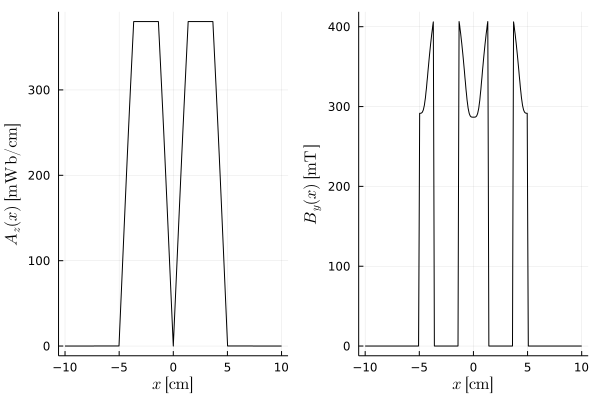

In [108]:
# Post-processing
ux    = zeros(Complex{Float64}, Na);
Jeddy = zeros(Complex{Float64}, Na);

Emat = 2 * [2, -4, 2] * [0 0.5 1] .+ [-3, 4, -1];
for i=1:length(edges) 
    xl, xm, xr = points[i,:][1];
    ul, um, ur = u[edges[i]];
    
    dux = [ul um ur] * Emat / (xr - xl);
    
    ux[edges[i]] += [dux[1]/2; dux[2]; dux[3]/2];
    
    if(i < N-1 && fsigma_elem[i+1] <= 0)
        Jeddy[edges[i]] += 1im * omega * fsigma_elem[i] * [ul/2 um ur]';
    elseif(i > 2 && fsigma_elem[i-1] <= 0)
        Jeddy[edges[i]] += 1im * omega * fsigma_elem[i] * [ul um ur/2]';
    else
        Jeddy[edges[i]] += 1im * omega * fsigma_elem[i] * [ul/2 um ur/2]';
    end
end

# Plot
p1 = plot(X * 1e2, norm.(u) * 1e5, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"A_z(x)\ \mathrm{[mWb/cm]}", color = :black, lw = 1, legend = false);
p2 = plot(X * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false);

plot(p1, p2)

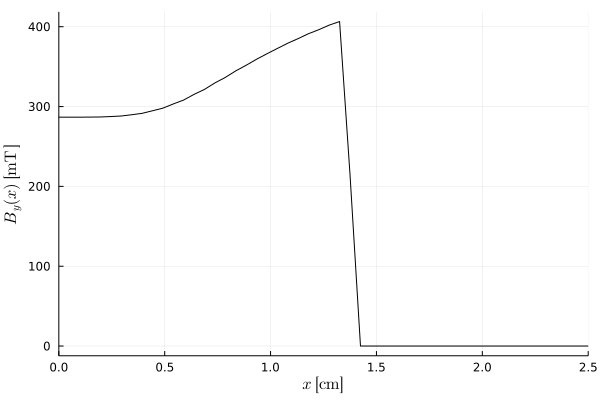

In [109]:
plot(X * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false)
xlims!((0, 2.5))

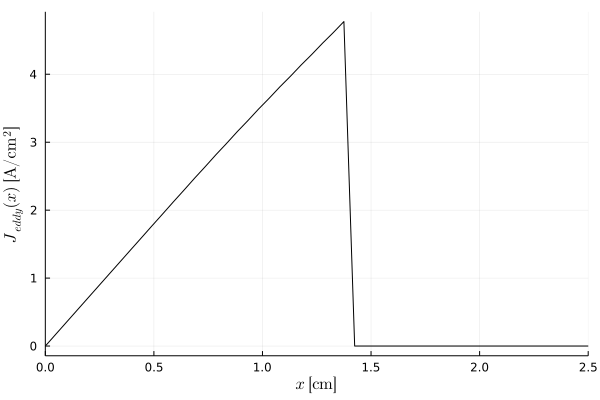

In [110]:
plot(X * 1e2, norm.(Jeddy) * 1e-4, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"J_{eddy}(x)\ \mathrm{[A/cm^2]}", color = :black, lw = 1, legend = false)
xlims!((0, 2.5))